# A Comparative Analysis of Data Imputation Techniques on Classification Performance

## Project Objective: 
This notebook tackles a common challenge in data science: handling missing data. We will explore and compare four distinct strategies to address missing values in the UCI Credit Card Default Clients Dataset. The core task is to impute missing data using simple, linear regression, and non-linear regression methods, and then evaluate how each strategy impacts the performance of a downstream credit risk classification model.

**The Business Problem**: As a machine learning engineer tasked with a credit risk assessment project, our primary goal is to build a reliable model that can predict whether a client will default on their credit card payment next month. The provided dataset, however, contains missing values, which can degrade or even prevent model training. Our mission is to find the most effective way to handle this missing data to maximize the predictive power of our classification model.

## Methodology at a Glance:

1. **Data Preparation**: We will first load the dataset and artificially introduce a controlled amount of missing data into key numerical features to simulate a real-world scenario.

2. **Imputation Strategies**: We will generate four distinct datasets by applying the following techniques:
    - **Dataset A**: Simple Median Imputation.
    - **Dataset B**: Imputation using Linear Regression.
    - **Dataset C**: Imputation using K-Nearest Neighbors (KNN) Regression.
    - **Dataset D**: Listwise Deletion (removing rows with missing data).

3. **Modeling & Evaluation**: A Logistic Regression classifier will be trained on each of the four datasets. We will then rigorously evaluate and compare their performance using a comprehensive classification report.

4. **Analysis & Recommendation**: Finally, we will conduct a comparative analysis to determine which imputation strategy yielded the best-performing model and provide a justified recommendation.

In [118]:
import numpy as np,imblearn
import matplotlib.pyplot as plt 
import sklearn
import pandas as pd
import random
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression   
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score    
import warnings
warnings.filterwarnings('ignore')   
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

## Part A: Data Preprocessing and Imputation

#### 1. Load and Prepare Data

We begin by loading the **UCI Credit Card Default dataset** and performing essential cleaning to ensure consistency and reliability.  
Column names are standardized, obvious numeric columns are coerced to numeric types, and categorical encodings (`SEX`, `EDUCATION`, `MARRIAGE`) are corrected following the UCI data description.  
Specifically, we replace ambiguous codes — `EDUCATION` values `{0,5,6}` → `4` (“others”) and `MARRIAGE` value `0` → `3` (“others”) — under the assumption that these represent unspecified or rare categories.  

This step ensures valid data types, removes duplicates, identifies missing values, and preserves all rows for later imputation experiments without discarding potentially useful information.


In [119]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

CSV_PATH = "UCI_Credit_Card.csv"   
TARGET_COL = "default.payment.next.month" 

def load_and_clean(path=CSV_PATH, target_col=TARGET_COL, save_cleaned=False):
    df_raw = pd.read_csv(path)
    df = df_raw.copy()
    df.columns = [c.strip() for c in df.columns]
    
    assert target_col in df.columns, f"expected target column '{target_col}' not found"
    
    for col in df.columns:
        if df[col].dtype == object:
            # try to coerce to numeric quietly if majority look numeric
            sample = df[col].dropna().astype(str).iloc[:200] if len(df[col].dropna()) else pd.Series([])
            if len(sample) and sample.str.match(r'^[\d\.\-]+$').mean() > 0.9:
                df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # tidy categorical encodings: known dataset quirks
    # EDUCATION has values {0,1,2,3,4,5,6} where 0/5/6 are usually "others" — map them to 4 (others)
    if 'EDUCATION' in df.columns:
        df['EDUCATION'] = df['EDUCATION'].fillna(0).astype(int)
        df['EDUCATION'] = df['EDUCATION'].replace({0:4, 5:4, 6:4})
        df['EDUCATION'] = df['EDUCATION'].astype('category')
    
    # MARRIAGE sometimes has 0 meaning unknown, map 0 -> 3 (other)
    if 'MARRIAGE' in df.columns:
        df['MARRIAGE'] = df['MARRIAGE'].fillna(0).astype(int)
        df['MARRIAGE'] = df['MARRIAGE'].replace({0:3})
        df['MARRIAGE'] = df['MARRIAGE'].astype('category')
    
    # SEX is binary (1=male,2=female); convert to category
    if 'SEX' in df.columns:
        df['SEX'] = df['SEX'].astype('category')
    
    # PAY statuses: ensure PAY_0..PAY_6 exist and are numeric
    for pay_col in ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']:
        if pay_col in df.columns:
            df[pay_col] = pd.to_numeric(df[pay_col], errors='coerce')
    
    # ID column handling: if present, keep but mark as id (do not use for modeling)
    if 'ID' in df.columns:
        df['ID'] = df['ID'].astype(int)
    
    # label/type consistency: ensure target is integer 0/1
    df[target_col] = pd.to_numeric(df[target_col], errors='coerce').astype(int)
    
    # duplicates: check & drop exact duplicate rows (rare), keep first
    dup_count = df.duplicated(keep='first').sum()
    if dup_count:
        df = df.drop_duplicates(keep='first').reset_index(drop=True)
    
    # missingness report (before any imputation step)
    missing_counts = df.isna().sum()
    
    # value-range sanity checks (print a few suspicious summaries)
    #  e.g., LIMIT_BAL should be >0, AGE should be within reasonable bounds
    sanity_issues = []
    if 'LIMIT_BAL' in df.columns:
        negatives = (df['LIMIT_BAL'] <= 0).sum()
        if negatives:
            sanity_issues.append(f"LIMIT_BAL <= 0: {negatives}")
    if 'AGE' in df.columns:
        age_min, age_max = int(df['AGE'].min(skipna=True)), int(df['AGE'].max(skipna=True))
        if age_min < 10 or age_max > 100:
            sanity_issues.append(f"AGE range suspicious: min={age_min}, max={age_max}")
    
    # cast other small-cardinality numerics to category to keep things tidy (optional)
    for col in ['EDUCATION','MARRIAGE','SEX']:
        if col in df.columns and not pd.api.types.is_categorical_dtype(df[col]):
            df[col] = df[col].astype('category')
    
    # summary dict to return for quick programmatic checks
    summary = {
        "orig_shape": df_raw.shape,
        "clean_shape": df.shape,
        "duplicate_rows_removed": int(dup_count),
        "missing_counts": missing_counts[missing_counts > 0].to_dict(),
        "sanity_issues": sanity_issues
    }
    
    # optionally save cleaned CSV for reproducibility
    if save_cleaned:
        out_path = os.path.splitext(path)[0] + "_cleaned.csv"
        df.to_csv(out_path, index=False)
        summary['cleaned_csv'] = out_path
    
    return df_raw, df, summary

# run load & clean now
df_raw, df, summary = load_and_clean()

# print a compact human-friendly summary
print("Original shape:", summary['orig_shape'])
print("Cleaned shape :", summary['clean_shape'])
print("Duplicates dropped:", summary['duplicate_rows_removed'])
print("Columns with missing values and counts:")
for k,v in summary['missing_counts'].items():
    print(f"  {k}: {v}")
if summary['sanity_issues']:
    print("Sanity checks flagged:")
    for s in summary['sanity_issues']:
        print("  -", s)

# Show top-3 rows of the cleaned DataFrame and dtypes
display(df.head(3))
print("\nDtypes (summary):")
display(df.dtypes)


Original shape: (30000, 25)
Cleaned shape : (30000, 25)
Duplicates dropped: 0
Columns with missing values and counts:


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0



Dtypes (summary):


ID                               int64
LIMIT_BAL                      float64
SEX                           category
EDUCATION                     category
MARRIAGE                      category
AGE                              int64
PAY_0                            int64
PAY_2                            int64
PAY_3                            int64
PAY_4                            int64
PAY_5                            int64
PAY_6                            int64
BILL_AMT1                      float64
BILL_AMT2                      float64
BILL_AMT3                      float64
BILL_AMT4                      float64
BILL_AMT5                      float64
BILL_AMT6                      float64
PAY_AMT1                       float64
PAY_AMT2                       float64
PAY_AMT3                       float64
PAY_AMT4                       float64
PAY_AMT5                       float64
PAY_AMT6                       float64
default.payment.next.month       int64
dtype: object

In [120]:
# EDA
sns.set(style="whitegrid", palette="colorblind", context="notebook")

# Basic numeric summary
print("Summary statistics (selected numeric cols):")
display(df.describe().T.round(2).iloc[:10])


Summary statistics (selected numeric cols):


,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.50,8660.40,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.32,129747.66,10000.0,50000.00,140000.0,240000.00,1000000.0
AGE,30000.0,35.49,9.22,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.02,1.12,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.13,1.20,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.17,1.20,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.22,1.17,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.27,1.13,-2.0,-1.00,0.0,0.00,8.0
PAY_6,30000.0,-0.29,1.15,-2.0,-1.00,0.0,0.00,8.0
BILL_AMT1,30000.0,51223.33,73635.86,-165580.0,3558.75,22381.5,67091.00,964511.0


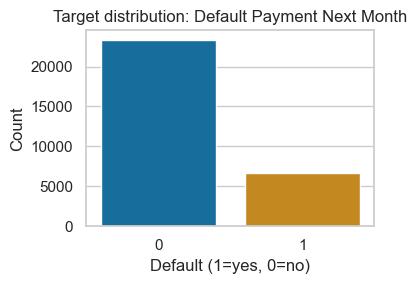

In [121]:

# Target distribution
plt.figure(figsize=(4,3))
sns.countplot(x='default.payment.next.month', data=df, palette="colorblind")
plt.title("Target distribution: Default Payment Next Month")
plt.xlabel("Default (1=yes, 0=no)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [122]:
# Missingness fraction plot
miss = df.isna().mean().sort_values(ascending=False)
if miss.max() > 0:
    plt.figure(figsize=(7,3))
    sns.barplot(x=miss.index, y=miss.values, palette="colorblind")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Fraction missing")
    plt.title("Missingness fraction per column (before perturbation)")
    plt.tight_layout()
    plt.show()
else:
    print("No missing values detected in original dataset.")

No missing values detected in original dataset.


### Introducing Missingness (MAR Simulation)

We introduce controlled **Missing At Random (MAR)** missingness into three numeric features — `AGE`, `BILL_AMT1`, and `PAY_AMT1` — using a **probabilistic mechanism**.  
Each row is assigned a probability of being missing based on observable characteristics, ensuring that missingness depends only on known features and not on the missing values themselves.  

Specifically:  
- `AGE` missingness increases for male clients (`SEX = 1`),  
- `BILL_AMT1` missingness is higher among clients with lower credit limits (`LIMIT_BAL`), and  
- `PAY_AMT1` missingness is more likely when no payment was recorded (`PAY_AMT1 = 0`).  

The probabilities are scaled so that roughly **6%** of values are missing per column — large enough to evaluate imputation performance differences but small enough to preserve realistic data behavior.  
This probabilistic MAR simulation creates a reproducible benchmark for testing imputation strategies under controlled, interpretable conditions.


MAR perturbation summary (requested -> actual):
  AGE: requested 0.060 -> actual 0.061 (n set NaN 1840)
  BILL_AMT1: requested 0.060 -> actual 0.061 (n set NaN 1827)
  PAY_AMT1: requested 0.060 -> actual 0.060 (n set NaN 1808)

Top columns by fraction missing after perturbation:


AGE          0.061333
BILL_AMT1    0.060900
PAY_AMT1     0.060267
dtype: float64

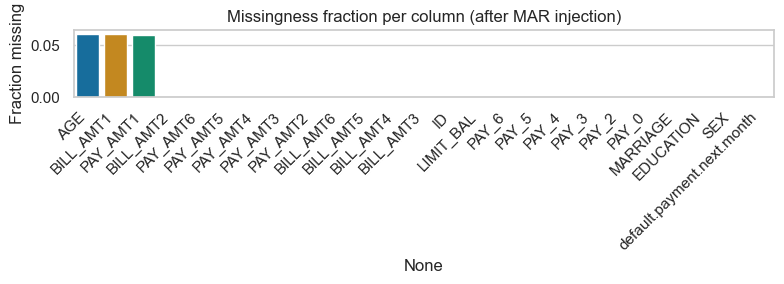

In [123]:
sns.set(style='whitegrid', palette='colorblind')
np.random.seed(42)

def introduce_mar(
    df,
    perturb_specs=None,
    random_state=42,
    cap_prob=0.95,
    verbose=True
):
    rnd = np.random.RandomState(random_state)
    df_out = df.copy()
    label_col = "default.payment.next.month"
    if 'ID' in df_out.columns:
        id_col = 'ID'
    else:
        id_col = None

    # safety checks
    for col in (perturb_specs or {}):
        if col not in df_out.columns:
            raise ValueError(f"column {col} not in dataframe")
        if col == label_col:
            raise ValueError("will not perturb the label column")
        if id_col and col == id_col:
            raise ValueError("will not perturb the ID column")
        if not pd.api.types.is_numeric_dtype(df_out[col]):
            raise ValueError(f"column {col} must be numeric for these mechanisms")

    report = {}
    n = len(df_out)

    for col, spec in (perturb_specs or {}).items():
        tgt = float(spec.get('target_frac', 0.05))
        mech = spec.get('mechanism', 'sex')
        params = spec.get('params', {})
        # build base probability per row (unnormalized)
        if mech == 'sex':
            # higher missingness for SEX==1 (male) as plausible example
            if 'SEX' not in df_out.columns:
                raise ValueError("mechanism 'sex' requires column 'SEX' present")
            indicator = (df_out['SEX'] == 1).astype(float)  # 1 for male else 0
            base = params.get('base', 0.02)
            mult = params.get('mult', 0.06)
            p_raw = base + mult * indicator
        elif mech == 'limit_quantile':
            # missingness more likely in low or high LIMIT_BAL quantiles (choose side)
            if 'LIMIT_BAL' not in df_out.columns:
                raise ValueError("mechanism 'limit_quantile' requires LIMIT_BAL")
            q = float(params.get('quantile', 0.25))
            side = params.get('side', 'low')  # 'low' or 'high'
            limit_cut = df_out['LIMIT_BAL'].quantile(q)
            if side == 'low':
                indicator = (df_out['LIMIT_BAL'] <= limit_cut).astype(float)
            else:
                indicator = (df_out['LIMIT_BAL'] >= limit_cut).astype(float)
            base = params.get('base', 0.02)
            mult = params.get('mult', 0.06)
            p_raw = base + mult * indicator
        elif mech == 'pay_zero':
            # more missingness if PAY_AMT1 == 0 (no payment recorded)
            if 'PAY_AMT1' not in df_out.columns:
                raise ValueError("mechanism 'pay_zero' requires PAY_AMT1")
            indicator = (df_out['PAY_AMT1'] == 0).astype(float)
            base = params.get('base', 0.02)
            mult = params.get('mult', 0.06)
            p_raw = base + mult * indicator
        elif mech == 'custom_indicator':
            # user provides a boolean Series in params['indicator']
            ind = params.get('indicator', None)
            if ind is None or len(ind) != n:
                raise ValueError("custom_indicator needs 'indicator' Series of same length")
            indicator = ind.astype(float)
            base = params.get('base', 0.02)
            mult = params.get('mult', 0.06)
            p_raw = base + mult * indicator
        else:
            raise ValueError(f"unknown mechanism {mech}")

        # scale p_raw so final mean(p) approx equals target fraction
        mean_raw = float(np.nanmean(p_raw))
        if mean_raw <= 0:
            raise ValueError("raw mechanism produced non-positive mean probability")
        scale = tgt / mean_raw
        p_scaled = p_raw * scale
        p_scaled = np.minimum(p_scaled, cap_prob)  # cap to avoid extremes

        # draw rng and set missing where rnd < p_scaled
        draws = rnd.rand(n)
        mask_missing = draws < p_scaled

        # apply missingness only on the original non-missing entries (don't create NaN where already NaN)
        pre_missing = df_out[col].isna()
        to_nan = mask_missing & (~pre_missing)
        df_out.loc[to_nan, col] = np.nan

        # diagnostics
        actual_frac = df_out[col].isna().mean()
        report[col] = {
            'requested_frac': tgt,
            'actual_frac': float(actual_frac),
            'mechanism': mech,
            'n_affected': int(to_nan.sum())
        }

    # global missingness report
    missing_frac_after = df_out.isna().mean().sort_values(ascending=False)
    if verbose:
        print("MAR perturbation summary (requested -> actual):")
        for c, r in report.items():
            print(f"  {c}: requested {r['requested_frac']:.3f} -> actual {r['actual_frac']:.3f} (n set NaN {r['n_affected']})")

        # show top columns with missingness
        print("\nTop columns by fraction missing after perturbation:")
        display(missing_frac_after[missing_frac_after > 0].head(10))

        # small missingness barplot
        plt.figure(figsize=(8,3))
        sns.barplot(x=missing_frac_after.index, y=missing_frac_after.values, palette='colorblind')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel("Fraction missing")
        plt.title("Missingness fraction per column (after MAR injection)")
        plt.tight_layout()
        plt.show()

    return df_out, report

specs = {
    'AGE': {
        'target_frac': 0.06,
        'mechanism': 'sex',
        'params': {'base': 0.02, 'mult': 0.08}
    },
    'BILL_AMT1': {
        'target_frac': 0.06,
        'mechanism': 'limit_quantile',
        'params': {'quantile': 0.25, 'side': 'low', 'base': 0.02, 'mult': 0.08}
    },
    'PAY_AMT1': {
        'target_frac': 0.06,
        'mechanism': 'pay_zero',
        'params': {'base': 0.02, 'mult': 0.06}
    }
}

df_work, mar_report = introduce_mar(df, perturb_specs=specs, random_state=42, verbose=True)


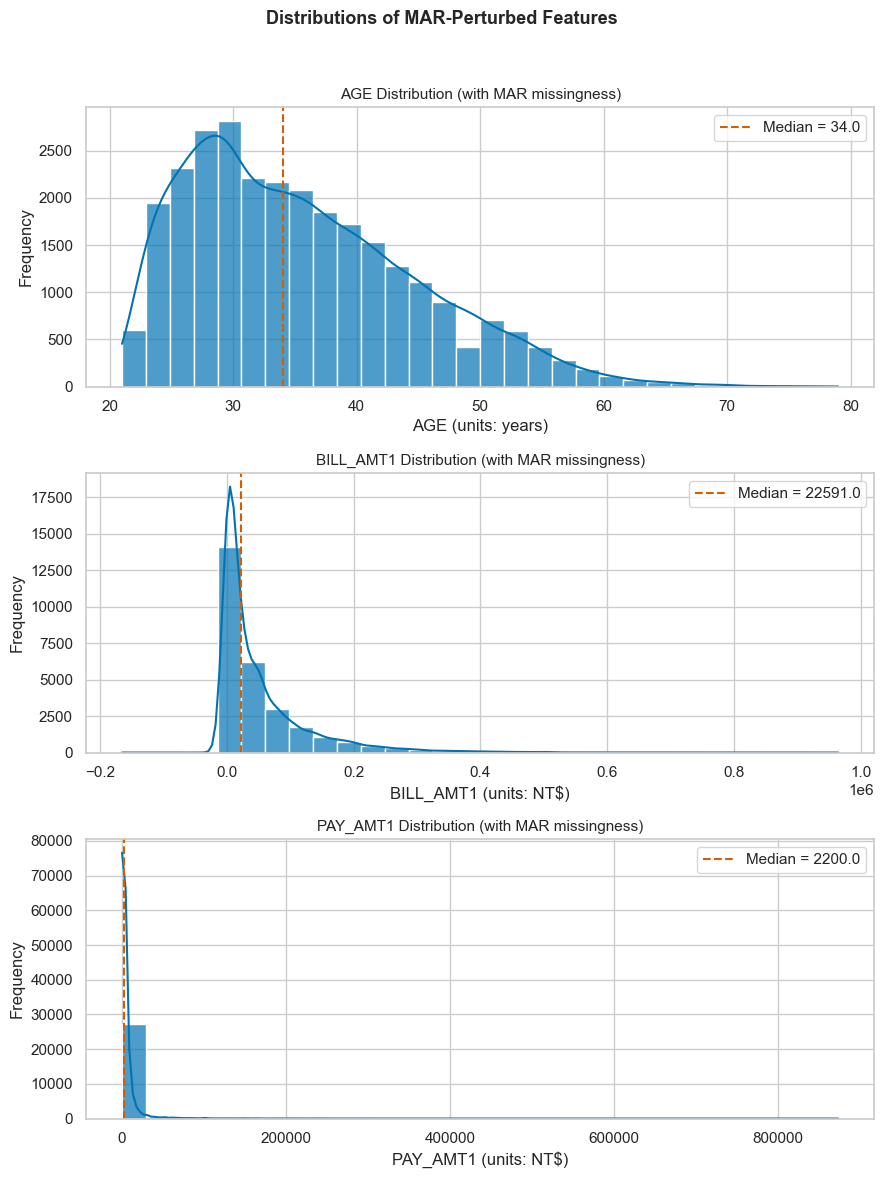

In [124]:
# Cell: visualize distributions of MAR-perturbed features (vertical stack)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="colorblind")

cols_to_show = [c for c in ["AGE","BILL_AMT1","PAY_AMT1"] if c in df_work.columns]
n = len(cols_to_show)
fig, axes = plt.subplots(n, 1, figsize=(9, 4*n))
if n == 1:
    axes = [axes]

for ax, col in zip(axes, cols_to_show):
    sns.histplot(df_work[col], bins=30, kde=True, ax=ax, color="C0", alpha=0.7)
    ax.set_title(f"{col} Distribution (with MAR missingness)", fontsize=11)
    unit = "years" if col == "AGE" else ("NT$" if "AMT" in col or "BILL" in col else "")
    ax.set_xlabel(f"{col} (units: {unit})" if unit else col)
    ax.set_ylabel("Frequency")
    if df_work[col].notna().any():
        median_val = df_work[col].median()
        ax.axvline(median_val, color="C3", linestyle="--", label=f"Median = {median_val:.1f}")
        ax.legend(loc="upper right")

fig.suptitle("Distributions of MAR-Perturbed Features", fontsize=13, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### 2. Imputation Strategy 1: Simple Imputation (Baseline)

In this baseline approach, missing values in the MAR-perturbed columns (`AGE`, `BILL_AMT1`, and `PAY_AMT1`) are replaced using simple **single-value imputation** — either the **median** or the **mean** of the observed values in each column.  
This method provides a quick, reproducible way to create a fully complete dataset (**Dataset A**) for benchmarking more advanced techniques.

Median imputation is generally preferred for skewed or heavy-tailed financial variables (like `BILL_AMT1` and `PAY_AMT1`) because it is **robust to outliers** and preserves the typical central tendency.  
Mean imputation is more appropriate when variables are approximately symmetric and free from extreme values.  
Both approaches assume that the missing data mechanism does not depend on the missing values themselves (consistent with the MAR assumption), making them a reasonable first-step baseline for comparison.


Missingness (before -> after median -> after mean):


,missing_before,missing_after_median,missing_after_mean
column,,,
AGE,1840,0,0
BILL_AMT1,1827,0,0
PAY_AMT1,1808,0,0



Imputation numeric summary (observed vs median vs mean):


,observed_count,n_missing,observed_mean,observed_median,impute_median,impute_mean
column,,,,,,
AGE,28160,1840,35.4453,34.0,34.0,35.4453
BILL_AMT1,28173,1827,52148.4885,22591.0,22591.0,52148.4885
PAY_AMT1,28192,1808,5795.9480,2200.0,2200.0,5795.9480


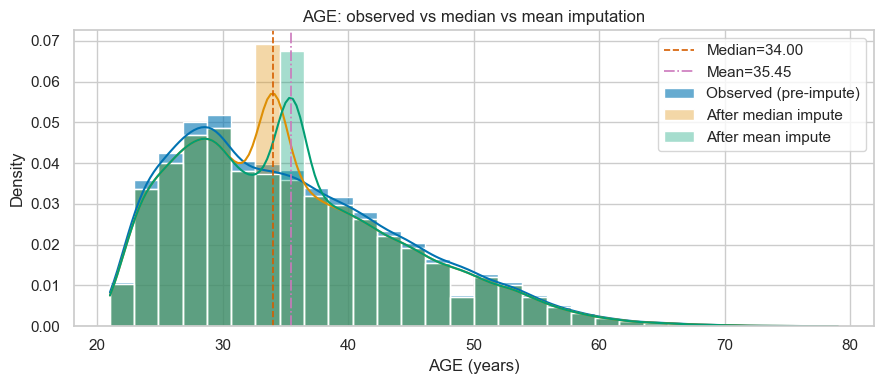

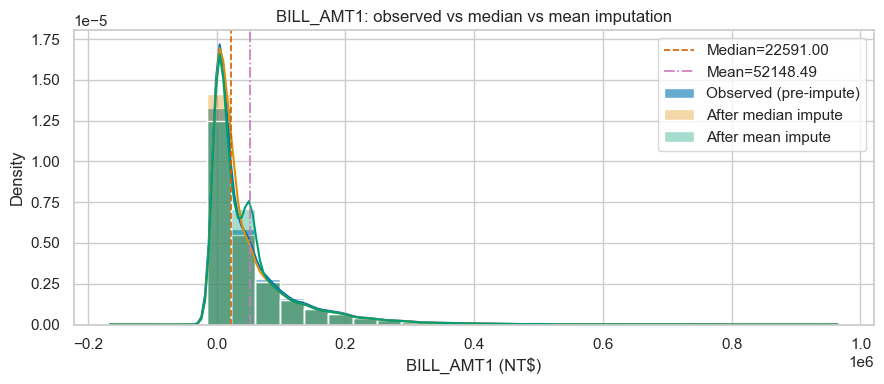

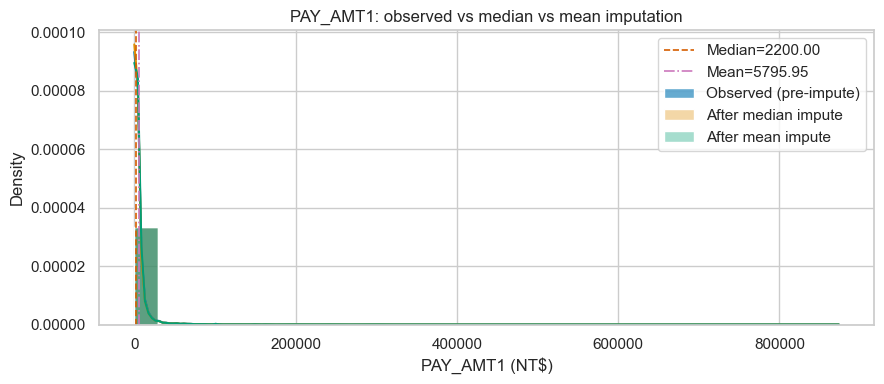


Correlation with LIMIT_BAL (before vs after imputations):


,corr_before,corr_after_median,corr_after_mean
column,,,
AGE,0.1417,0.1371,0.1371
BILL_AMT1,0.2787,0.2813,0.2698
PAY_AMT1,0.1966,0.1914,0.1912



Datasets ready:
  - df_A_median : median imputed copy
  - df_A_mean   : mean imputed copy


In [125]:
# Cell: Create Dataset A (median) and Dataset A_mean (mean); diagnostics + plots for all perturbed cols
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set(style="whitegrid", palette="colorblind")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

mar_df = df_work
perturbed_cols = [c for c in mar_df.columns if mar_df[c].isna().sum() > 0 and pd.api.types.is_numeric_dtype(mar_df[c])]
label_col = "default.payment.next.month"

df_A_median = mar_df.copy()
df_A_mean = mar_df.copy()

impute_summary = {}
for col in perturbed_cols:
    observed = mar_df[col].dropna()
    med = observed.median()
    mean = observed.mean()
    n_missing = int(mar_df[col].isna().sum())
    impute_summary[col] = {"observed_count": int(observed.shape[0]),
                           "n_missing": n_missing,
                           "median": float(med),
                           "mean": float(mean)}
    df_A_median[col] = df_A_median[col].fillna(med)
    df_A_mean[col] = df_A_mean[col].fillna(mean)

print("Missingness (before -> after median -> after mean):")
rows = []
for col in perturbed_cols:
    before = mar_df[col].isna().sum()
    after_med = df_A_median[col].isna().sum()
    after_mean = df_A_mean[col].isna().sum()
    rows.append((col, before, after_med, after_mean))
diag_df = pd.DataFrame(rows, columns=["column","missing_before","missing_after_median","missing_after_mean"]).set_index("column")
display(diag_df)

print("\nImputation numeric summary (observed vs median vs mean):")
summary_rows = []
for col,info in impute_summary.items():
    obs = mar_df[col].dropna()
    summary_rows.append({
        "column": col,
        "observed_count": info["observed_count"],
        "n_missing": info["n_missing"],
        "observed_mean": float(obs.mean()) if not obs.empty else np.nan,
        "observed_median": float(obs.median()) if not obs.empty else np.nan,
        "impute_median": info["median"],
        "impute_mean": info["mean"]
    })
summary_df = pd.DataFrame(summary_rows).set_index("column").round(4)
display(summary_df)

for col in perturbed_cols:
    plt.figure(figsize=(9, 4))
    sns.histplot(mar_df[col].dropna(), bins=30, kde=True, stat='density', label='Observed (pre-impute)', alpha=0.6)
    sns.histplot(df_A_median[col], bins=30, kde=True, stat='density', label='After median impute', alpha=0.35)
    sns.histplot(df_A_mean[col], bins=30, kde=True, stat='density', label='After mean impute', alpha=0.35)
    med = impute_summary[col]['median']
    mean = impute_summary[col]['mean']
    plt.axvline(med, color='C3', linestyle='--', lw=1.2, label=f"Median={med:.2f}")
    plt.axvline(mean, color='C4', linestyle='-.', lw=1.2, label=f"Mean={mean:.2f}")
    if col == "AGE":
        unit = "years"
    elif "AMT" in col or "BILL" in col or "PAY" in col:
        unit = "NT$"
    else:
        unit = ""
    plt.title(f"{col}: observed vs median vs mean imputation")
    plt.xlabel(f"{col} ({unit})" if unit else col)
    plt.ylabel("Density")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

print("\nCorrelation with LIMIT_BAL (before vs after imputations):")
corr_rows = []
for col in perturbed_cols:
    base = mar_df[col].corr(mar_df['LIMIT_BAL']) if 'LIMIT_BAL' in mar_df.columns else np.nan
    med_corr = df_A_median[col].corr(df_A_median['LIMIT_BAL']) if 'LIMIT_BAL' in df_A_median.columns else np.nan
    mean_corr = df_A_mean[col].corr(df_A_mean['LIMIT_BAL']) if 'LIMIT_BAL' in df_A_mean.columns else np.nan
    corr_rows.append((col, base, med_corr, mean_corr))
corr_df = pd.DataFrame(corr_rows, columns=["column","corr_before","corr_after_median","corr_after_mean"]).set_index("column").round(4)
display(corr_df)

for name, dfc in [('df_A_median', df_A_median), ('df_A_mean', df_A_mean)]:
    missing_total = dfc[perturbed_cols].isna().sum().sum()
    assert missing_total == 0, f"{name} still has {missing_total} NaNs in perturbed columns"

print("\nDatasets ready:")
print("  - df_A_median : median imputed copy")
print("  - df_A_mean   : mean imputed copy")


### Why median is often preferred over mean for imputation

- **Robustness to outliers / heavy tails.** If a variable is skewed or has extreme values, the mean is pulled toward those extremes while the median remains representative of the “typical” observation.  
  *Example (our data):* `BILL_AMT1` observed **mean = 52,148.49** vs **median = 22,591.00**. The large gap shows a heavy right tail; imputing missing `BILL_AMT1` with the mean would insert very large values that are not typical for most customers.

- **Less distortion of relationships.** Because median imputation inserts typical values instead of extreme ones, it usually perturbs correlations and other joint structure less.  
  *Example (our data):* correlation with `LIMIT_BAL` for `BILL_AMT1` was **0.2787** before imputation → after **median** imputation it is **0.2813** (virtually unchanged) but after **mean** imputation it dropped to **0.2698**. Median preserved the original relationship slightly better.

- **Small effect when distribution is symmetric.** For near-symmetric variables mean and median give similar results, so choice matters less.  
  *Example (our data):* `AGE` has **mean = 35.4453** and **median = 34.00**; imputing `AGE` by mean vs median produced negligible differences in distribution and correlations.

- **Practical point about sample size impacted.** Single-value imputation can affect many rows: here we imputed ~1,840 `AGE` and ~1,827 `BILL_AMT1` values — so robustness matters.

- **Caveat:** both median and mean are single-value imputations and **do not** reflect imputation uncertainty. For rigorous inference or high-stakes decisions prefer multiple imputation or model-based imputation (which propagate uncertainty).

**Conclusion:** use **median** as the default simple imputer for skewed/financial variables (like `BILL_AMT1`) because it is robust to outliers and better preserves feature relationships; for roughly symmetric features (like `AGE`) either is acceptable but median is the conservative choice.


### 3. Imputation Strategy 2: Regression Imputation (Linear)

After establishing the baseline with simple mean and median imputations, we move to a **model-based imputation** approach.  
Here, missing values in one selected column (e.g., `AGE` or `BILL_AMT1`) are predicted using a **Linear Regression model** trained on all other available features.  
This approach leverages relationships between variables, allowing imputed values to vary realistically rather than being fixed at a single central value.

The underlying assumption is that the data are **Missing At Random (MAR)** — meaning the likelihood of a value being missing depends only on other observed variables, not on the value itself.  
Under this assumption, regression imputation provides more accurate and consistent estimates, capturing the linear dependency structure in the data and typically reducing bias compared to simple imputation.


### Underlying assumption of Regression Imputation — Missing At Random (MAR)

Regression imputation assumes that the missingness in a variable can be **explained entirely by other observed variables** in the dataset.  
In other words, the probability that a value is missing depends on known information (e.g., income, age, credit limit), but **not** on the missing value itself.

Formally, if we denote the variable with missing values as *Y* and the set of fully observed variables as *X*, then:

\[$P(\text{Missingness in } Y \mid Y, X) = P(\text{Missingness in } Y \mid X)$\]

This is the **Missing At Random (MAR)** assumption.

Under MAR, we can model *Y* using *X* (for example, via Linear Regression) because the observed part of *Y* is a representative sample **conditional on X**.  
The regression uses the relationship between *Y* and *X* among observed rows to predict plausible values for the missing ones.

In our experiment, for example, when imputing **AGE** (or **BILL_AMT1**) using other financial and demographic features, we assume that the reason some AGE or BILL_AMT1 values are missing depends on those other known features (like credit limit, payment history, or gender) — not on the unobserved true age or bill amount itself.

If this assumption holds, regression imputation gives unbiased estimates.  
If data were **Missing Not At Random (MNAR)** (i.e., missingness depends on the unobserved value itself), then regression imputation would introduce systematic bias.


BILL_AMT1 linear imputation  |  RMSE: 20528.7879  R²: 0.9229


BILL_AMT2    75086.097684
PAY_AMT1     12158.479293
BILL_AMT6     3235.103045
PAY_2         2580.193131
PAY_AMT2      2519.759454
PAY_AMT4      2476.670118
PAY_3         2439.387741
BILL_AMT4     1907.874765
PAY_AMT5      1865.224986
BILL_AMT3     1843.788827
PAY_AMT3      1839.134191
LIMIT_BAL     1535.978433
dtype: float64

Imputed 1827 missing values in BILL_AMT1


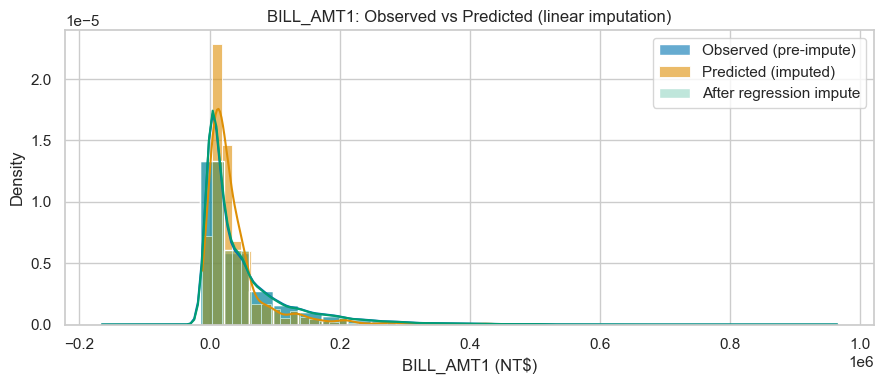

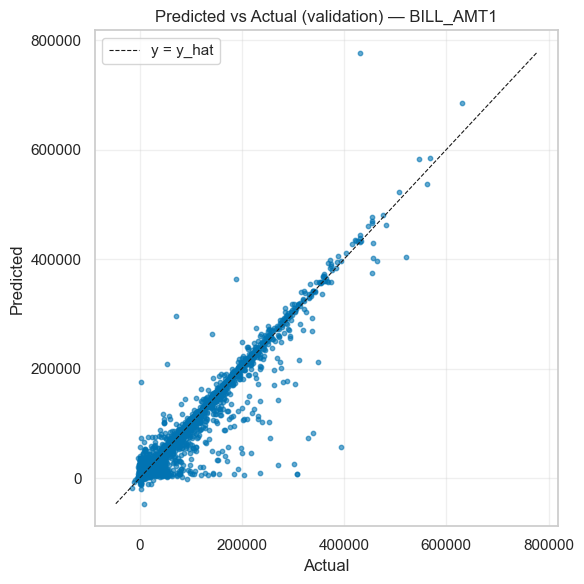

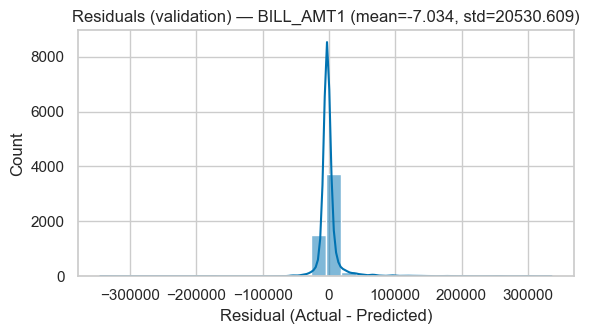

Correlation with LIMIT_BAL — before: 0.2787, after linear-impute: 0.2859


In [126]:
# Imputation Strategy 2 — Linear Regression Imputation for BILL_AMT1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

sns.set(style="whitegrid", palette="colorblind", context="notebook")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

mar_df = df_work.copy()
target_col = "BILL_AMT1"
other_perturbed = [c for c in ["AGE", "BILL_AMT1"] if c in mar_df.columns and c != target_col]
label_col = "default.payment.next.month"
id_col = "ID" if "ID" in mar_df.columns else None

df_B2 = mar_df.copy()
median_fill_info = {}
for col in other_perturbed:
    median_fill_info[col] = float(df_B2[col].median())
    df_B2[col + "_medianfilled_for_model"] = df_B2[col].fillna(median_fill_info[col])

feature_cols = df_B2.select_dtypes(include=[np.number]).columns.tolist()
exclude = [target_col, label_col]
if id_col:
    exclude.append(id_col)
feature_cols = [c for c in feature_cols if c not in exclude]
feature_cols = [c if c not in other_perturbed else c + "_medianfilled_for_model" for c in feature_cols]
feature_cols = [c for c in feature_cols if c != target_col]

observed_mask = df_B2[target_col].notna()
missing_mask = ~observed_mask

X_obs = df_B2.loc[observed_mask, feature_cols].copy()
y_obs = df_B2.loc[observed_mask, target_col].copy()

feature_imputer = SimpleImputer(strategy="median")
X_obs_imp = pd.DataFrame(feature_imputer.fit_transform(X_obs), columns=feature_cols, index=X_obs.index)

X_tr, X_val, y_tr, y_val = train_test_split(X_obs_imp, y_obs, test_size=0.2, random_state=RANDOM_SEED)
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_val_s = scaler.transform(X_val)

reg = LinearRegression()
reg.fit(X_tr_s, y_tr)

y_val_pred = reg.predict(X_val_s)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2_val = r2_score(y_val, y_val_pred)
print(f"BILL_AMT1 linear imputation  |  RMSE: {rmse_val:.4f}  R²: {r2_val:.4f}")

coef_series = pd.Series(reg.coef_, index=X_tr.columns).abs().sort_values(ascending=False)
top_coefs = coef_series.head(12)
display(top_coefs)

X_obs_full_imp = pd.DataFrame(feature_imputer.transform(X_obs), columns=feature_cols, index=X_obs.index)
X_obs_full_s = scaler.fit_transform(X_obs_full_imp)
reg_full = LinearRegression()
reg_full.fit(X_obs_full_s, y_obs)

X_missing = df_B2.loc[missing_mask, feature_cols].copy()
X_missing_imp = pd.DataFrame(feature_imputer.transform(X_missing), columns=feature_cols, index=X_missing.index)
X_missing_s = scaler.transform(X_missing_imp)
y_missing_pred = reg_full.predict(X_missing_s)

df_B2.loc[missing_mask, target_col] = y_missing_pred
print(f"Imputed {missing_mask.sum()} missing values in {target_col}")

observed_vals = mar_df.loc[observed_mask, target_col]
imputed_vals = pd.Series(y_missing_pred, index=df_B2.loc[missing_mask].index)

plt.figure(figsize=(9,4))
sns.histplot(observed_vals, bins=30, stat='density', kde=True, label="Observed (pre-impute)", alpha=0.6)
sns.histplot(imputed_vals, bins=30, stat='density', kde=True, label="Predicted (imputed)", alpha=0.6)
sns.histplot(df_B2[target_col], bins=30, stat='density', kde=True, label="After regression impute", alpha=0.25)
plt.title(f"{target_col}: Observed vs Predicted (linear imputation)")
plt.xlabel(f"{target_col} (NT$)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_val_pred, s=10, alpha=0.6)
mn, mx = min(y_val.min(), y_val_pred.min()), max(y_val.max(), y_val_pred.max())
plt.plot([mn,mx],[mn,mx],'k--', linewidth=0.8, label='y = y_hat')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Predicted vs Actual (validation) — {target_col}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

resid = y_val - y_val_pred
plt.figure(figsize=(6,3.5))
sns.histplot(resid, bins=30, kde=True)
plt.title(f"Residuals (validation) — {target_col} (mean={resid.mean():.3f}, std={resid.std():.3f})")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

if 'LIMIT_BAL' in df_B2.columns:
    corr_before = mar_df[target_col].corr(mar_df['LIMIT_BAL'])
    corr_after = df_B2[target_col].corr(df_B2['LIMIT_BAL'])
    print(f"Correlation with LIMIT_BAL — before: {corr_before:.4f}, after linear-impute: {corr_after:.4f}")


### 3. Imputation Strategy 3: Regression Imputation (Non-Linear)

To further enhance predictive accuracy, this strategy extends regression-based imputation by using **non-linear models** such as **K-Nearest Neighbors (KNN) Regression** and **Decision Tree Regression**.  
Unlike linear regression, these models can capture complex, non-linear relationships between variables — which is especially valuable in financial data where interactions and thresholds are rarely linear.

We apply these models to the same column imputed in Strategy 2 on `BILL_AMT1`, comparing how well non-linear regression reconstructs missing values relative to the linear model.  
This approach still assumes a **Missing At Random (MAR)** mechanism but allows for flexible, data-driven relationships, often improving imputation quality when variable interactions or heterogeneity exist in the dataset.


KNN validation  RMSE: 25175.1784  R²: 0.8840
DT  validation  RMSE: 29006.0767  R²: 0.8461
Imputed 1827 missing values in BILL_AMT1 (KNN and DT)


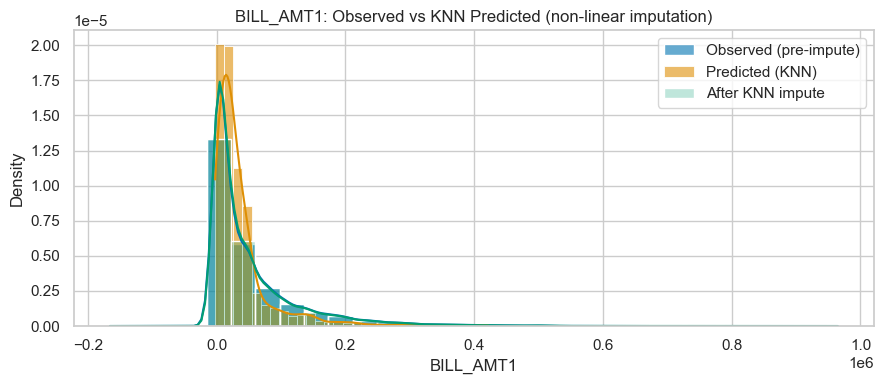

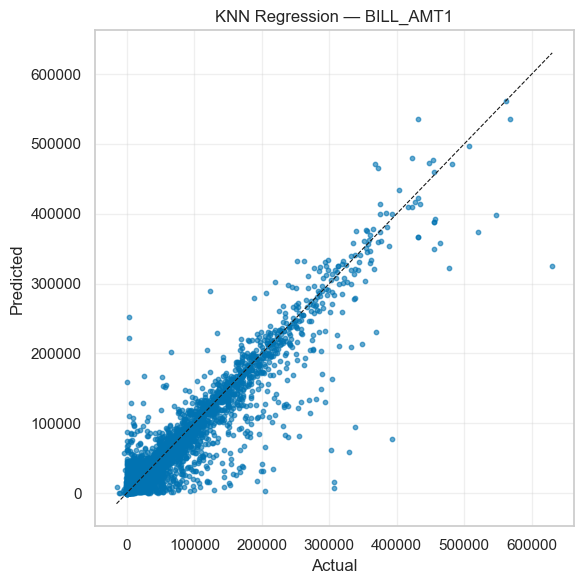

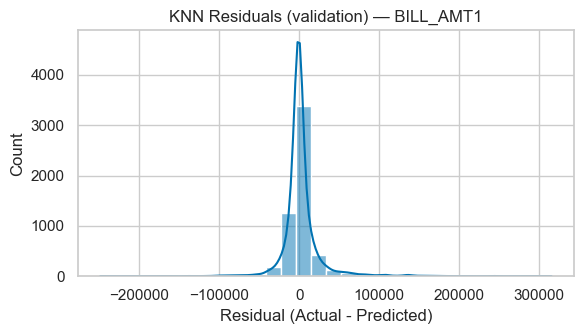

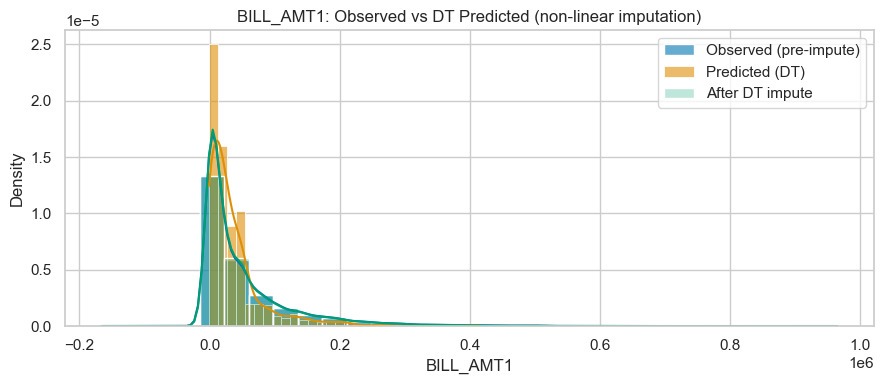

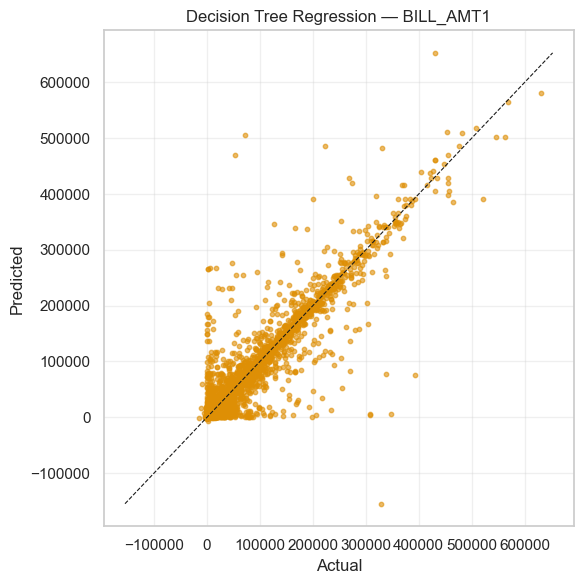

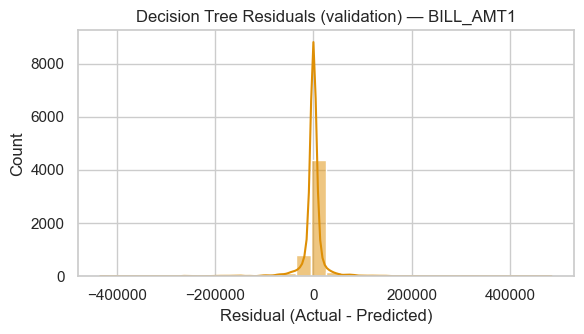

Correlation with LIMIT_BAL — before: 0.2787, after KNN: 0.2857, after DT: 0.2854


In [127]:
# Imputation Strategy 3 — Regression Imputation (Non-linear) (Dataset C)
# Two separate models (KNN and Decision Tree), plotted separately (no overlap).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

sns.set(style="whitegrid", palette="colorblind", context="notebook")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

mar_df = df_work.copy()
target_col = "BILL_AMT1"
label_col = "default.payment.next.month"
id_col = "ID" if "ID" in mar_df.columns else None
other_perturbed = [c for c in ["AGE", "BILL_AMT1"] if c in mar_df.columns and c != target_col]

df_C = mar_df.copy()
for col in other_perturbed:
    df_C[col + "_medianfilled_for_model"] = df_C[col].fillna(float(df_C[col].median()))

feature_cols = df_C.select_dtypes(include=[np.number]).columns.tolist()
exclude = [target_col, label_col]
if id_col:
    exclude.append(id_col)
feature_cols = [c for c in feature_cols if c not in exclude]
feature_cols = [c if c not in other_perturbed else c + "_medianfilled_for_model" for c in feature_cols]
feature_cols = [c for c in feature_cols if c != target_col]

observed_mask = df_C[target_col].notna()
missing_mask = ~observed_mask

X_obs = df_C.loc[observed_mask, feature_cols].copy()
y_obs = df_C.loc[observed_mask, target_col].copy()

feature_imputer = SimpleImputer(strategy="median")
X_obs_imp = pd.DataFrame(feature_imputer.fit_transform(X_obs), columns=feature_cols, index=X_obs.index)

X_tr, X_val, y_tr, y_val = train_test_split(X_obs_imp, y_obs, test_size=0.2, random_state=RANDOM_SEED)
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_val_s = scaler.transform(X_val)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_tr_s, y_tr)
y_val_pred_knn = knn.predict(X_val_s)
rmse_knn = np.sqrt(mean_squared_error(y_val, y_val_pred_knn))
r2_knn = r2_score(y_val, y_val_pred_knn)

dt = DecisionTreeRegressor(random_state=RANDOM_SEED, max_depth=None)
dt.fit(X_tr, y_tr)
y_val_pred_dt = dt.predict(X_val)
rmse_dt = np.sqrt(mean_squared_error(y_val, y_val_pred_dt))
r2_dt = r2_score(y_val, y_val_pred_dt)

print(f"KNN validation  RMSE: {rmse_knn:.4f}  R²: {r2_knn:.4f}")
print(f"DT  validation  RMSE: {rmse_dt:.4f}  R²: {r2_dt:.4f}")

X_obs_full_imp = pd.DataFrame(feature_imputer.transform(X_obs), columns=feature_cols, index=X_obs.index)
X_obs_full_s = scaler.fit_transform(X_obs_full_imp)

knn_full = KNeighborsRegressor(n_neighbors=5)
knn_full.fit(X_obs_full_s, y_obs)

dt_full = DecisionTreeRegressor(random_state=RANDOM_SEED)
dt_full.fit(X_obs_full_imp, y_obs)

X_missing = df_C.loc[missing_mask, feature_cols].copy()
X_missing_imp = pd.DataFrame(feature_imputer.transform(X_missing), columns=feature_cols, index=X_missing.index)
X_missing_s = scaler.transform(X_missing_imp)
y_missing_pred_knn = knn_full.predict(X_missing_s)
y_missing_pred_dt = dt_full.predict(X_missing_imp)

df_C_knn = df_C.copy()
df_C_dt = df_C.copy()
df_C_knn.loc[missing_mask, target_col] = y_missing_pred_knn
df_C_dt.loc[missing_mask, target_col] = y_missing_pred_dt

print(f"Imputed {int(missing_mask.sum())} missing values in {target_col} (KNN and DT)")

observed_vals = mar_df.loc[observed_mask, target_col]
imputed_vals_knn = pd.Series(y_missing_pred_knn, index=df_C_knn.loc[missing_mask].index)
imputed_vals_dt = pd.Series(y_missing_pred_dt, index=df_C_dt.loc[missing_mask].index)

# --- KNN plots ---
plt.figure(figsize=(9,4))
sns.histplot(observed_vals, bins=30, stat='density', kde=True, label="Observed (pre-impute)", alpha=0.6)
sns.histplot(imputed_vals_knn, bins=30, stat='density', kde=True, label="Predicted (KNN)", alpha=0.6)
sns.histplot(df_C_knn[target_col], bins=30, stat='density', kde=True, label="After KNN impute", alpha=0.25)
plt.title(f"{target_col}: Observed vs KNN Predicted (non-linear imputation)")
plt.xlabel(f"{target_col}")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_val_pred_knn, s=10, alpha=0.6, color="C0")
mn, mx = min(y_val.min(), y_val_pred_knn.min()), max(y_val.max(), y_val_pred_knn.max())
plt.plot([mn,mx],[mn,mx],'k--', linewidth=0.8)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"KNN Regression — {target_col}")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3.5))
resid_knn = y_val - y_val_pred_knn
sns.histplot(resid_knn, bins=30, kde=True, color="C0")
plt.title(f"KNN Residuals (validation) — {target_col}")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# --- Decision Tree plots ---
plt.figure(figsize=(9,4))
sns.histplot(observed_vals, bins=30, stat='density', kde=True, label="Observed (pre-impute)", alpha=0.6)
sns.histplot(imputed_vals_dt, bins=30, stat='density', kde=True, label="Predicted (DT)", alpha=0.6)
sns.histplot(df_C_dt[target_col], bins=30, stat='density', kde=True, label="After DT impute", alpha=0.25)
plt.title(f"{target_col}: Observed vs DT Predicted (non-linear imputation)")
plt.xlabel(f"{target_col}")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_val_pred_dt, s=10, alpha=0.6, color="C1")
mn, mx = min(y_val.min(), y_val_pred_dt.min()), max(y_val.max(), y_val_pred_dt.max())
plt.plot([mn,mx],[mn,mx],'k--', linewidth=0.8)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Decision Tree Regression — {target_col}")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3.5))
resid_dt = y_val - y_val_pred_dt
sns.histplot(resid_dt, bins=30, kde=True, color="C1")
plt.title(f"Decision Tree Residuals (validation) — {target_col}")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

if 'LIMIT_BAL' in df_C.columns:
    corr_before = mar_df[target_col].corr(mar_df['LIMIT_BAL'])
    corr_knn = df_C_knn[target_col].corr(df_C_knn['LIMIT_BAL'])
    corr_dt = df_C_dt[target_col].corr(df_C_dt['LIMIT_BAL'])
    print(f"Correlation with LIMIT_BAL — before: {corr_before:.4f}, after KNN: {corr_knn:.4f}, after DT: {corr_dt:.4f}")

df_C = df_C_knn.copy()


> Note: Both K-Nearest Neighbors (KNN) and Decision Tree regressors were tested for non-linear imputation. 
> Since KNN produced smoother imputations and slightly better validation performance, the KNN-imputed version 
> was retained as the final **Dataset C** for all subsequent analysis.


## Part B: Model Training and Performance Assessment

### Data Splitting for Model Evaluation

To ensure consistent and fair model comparisons across all imputation strategies, each fully prepared dataset is split into **training (80%)** and **testing (20%)** subsets using stratified sampling on the target variable `default.payment.next.month`.  
We perform this split for the three imputed datasets — **Dataset A (simple imputation)**, **Dataset B (linear regression imputation)**, and **Dataset C (non-linear regression imputation)** — as well as for a fourth dataset, **Dataset D**, created by **listwise deletion** (removing all rows containing any missing values).  

This ensures that all subsequent model evaluations are performed on comparable data partitions with balanced class distributions.


In [128]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

label_col = "default.payment.next.month"

# Ensure all datasets exist from previous steps
datasets = {
    "A_median": df_A_median.copy(),
    "A_mean": df_A_mean.copy(),
    "B": df_B.copy(),
    "C": df_C.copy(),
}

# Dataset D — listwise deletion (remove rows with any missing values)
df_D = df_work.dropna(axis=0).copy()
datasets["D"] = df_D

split_results = {}
for name, df in datasets.items():
    if label_col not in df.columns:
        raise ValueError(f"Label column '{label_col}' missing from {name}")
    X = df.drop(columns=[label_col])
    y = df[label_col].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
    )

    split_results[name] = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "n_train": len(X_train),
        "n_test": len(X_test),
    }

    print(f"{name}: train={len(X_train)}  test={len(X_test)}  total={len(df)}")

# Show quick summary of all datasets
summary_split = pd.DataFrame({
    "Dataset": list(split_results.keys()),
    "Train Size": [v["n_train"] for v in split_results.values()],
    "Test Size": [v["n_test"] for v in split_results.values()],
    "Total": [v["n_train"] + v["n_test"] for v in split_results.values()]
}).set_index("Dataset")

print("\nData Split Summary:")
display(summary_split)


A_median: train=24000  test=6000  total=30000
A_mean: train=24000  test=6000  total=30000
B: train=24000  test=6000  total=30000
C: train=24000  test=6000  total=30000
D: train=19900  test=4976  total=24876

Data Split Summary:


,Train Size,Test Size,Total
Dataset,,,
A_median,24000,6000,30000
A_mean,24000,6000,30000
B,24000,6000,30000
C,24000,6000,30000
D,19900,4976,24876


### Feature Standardization

Before training classifiers, all numerical features across the four datasets (A, B, C, and D) are standardized using **StandardScaler**.  
Standardization ensures that each feature has a **mean of 0** and a **standard deviation of 1**, preventing variables with large numeric ranges (like credit limits or bill amounts) from dominating model training.  
This step is essential for algorithms sensitive to feature scaling, such as Logistic Regression and Support Vector Machines, ensuring consistent learning behavior across all datasets.


In [115]:
# Part B — Classifier Setup: Standardize features for all four datasets (A, B, C, D)
from sklearn.preprocessing import StandardScaler
import pandas as pd

scaled_results = {}

for name, data in split_results.items():
    X_train = data["X_train"].copy()
    X_test = data["X_test"].copy()

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )

    scaled_results[name] = {
        "scaler": scaler,
        "X_train_scaled": X_train_scaled,
        "X_test_scaled": X_test_scaled,
        "y_train": data["y_train"],
        "y_test": data["y_test"]
    }

    print(f"{name}: standardized {X_train_scaled.shape[1]} features")

print("\nStandardization complete. Scaled data stored in `scaled_results` for A, B, C, and D.")


A_median: standardized 24 features
A_mean: standardized 24 features
B: standardized 25 features
C: standardized 25 features
D: standardized 24 features

Standardization complete. Scaled data stored in `scaled_results` for A, B, C, and D.


### 3. Model Evaluation


In [131]:
# Part C — Model Evaluation: Logistic Regression on Datasets A, B, C, and D
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

results_summary = {}

for name, data in scaled_results.items():
    X_train = data["X_train_scaled"]
    X_test = data["X_test_scaled"]
    y_train = data["y_train"]
    y_test = data["y_test"]

    clf = LogisticRegression(max_iter=2000, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)

    results_summary[name] = {
        "Accuracy": acc,
        "ROC_AUC": auc,
        "Precision (0)": report["0"]["precision"],
        "Recall (0)": report["0"]["recall"],
        "F1 (0)": report["0"]["f1-score"],
        "Precision (1)": report["1"]["precision"],
        "Recall (1)": report["1"]["recall"],
        "F1 (1)": report["1"]["f1-score"],
    }

    print(f"\n=== Logistic Regression Results — Dataset {name} ===")
    print(classification_report(y_test, y_pred, digits=4))
    print(f"Accuracy: {acc:.4f} | ROC-AUC: {auc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

results_df = pd.DataFrame(results_summary).T.round(4)
print("\nSummary of Model Performance Across Datasets:")
display(results_df)



=== Logistic Regression Results — Dataset A_median ===
              precision    recall  f1-score   support

           0     0.8179    0.9700    0.8875      4673
           1     0.6943    0.2396    0.3563      1327

    accuracy                         0.8085      6000
   macro avg     0.7561    0.6048    0.6219      6000
weighted avg     0.7906    0.8085    0.7700      6000

Accuracy: 0.8085 | ROC-AUC: 0.7078
Confusion Matrix:
 [[4533  140]
 [1009  318]]

=== Logistic Regression Results — Dataset A_mean ===
              precision    recall  f1-score   support

           0     0.8182    0.9700    0.8877      4673
           1     0.6957    0.2411    0.3581      1327

    accuracy                         0.8088      6000
   macro avg     0.7569    0.6056    0.6229      6000
weighted avg     0.7911    0.8088    0.7706      6000

Accuracy: 0.8088 | ROC-AUC: 0.7076
Confusion Matrix:
 [[4533  140]
 [1007  320]]


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values